<a href="https://colab.research.google.com/github/h0806449f/PyTorch/blob/main/DB_08_vision_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **=== 0. 簡介 ===**
1. Set up
2. Raw data & Dataset & Dataloader
4. Vision transformer (ViT)
    * Equation_1: patch embedding
    * Equation_2: multi-head attention
    * Equation_3: multi-layer perceptron
    * Equation_4
5. Train
6. Transfor for vit
7. Make prediction

# **=== 1. Set up ===**

In [1]:
!pip install torchinfo

In [2]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary

import matplotlib.pyplot as plt

# **=== 2. Raw data, dataset, dataloader ===**

## 2.1 Raw data

In [3]:
import os
import zipfile
import requests
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "db_image_data"

if image_path.is_dir():
    print(f"[INFO] {image_path} directory already exists.")
else:
    print(f"[INFO] {image_path} not exists, creating ...")
    image_path.mkdir(parents = True, exist_ok = True)

    with open(data_path / "db_image_data.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print(f"[INFO] zip file downloading ...")
        f.write(request.content)

    with zipfile.ZipFile(data_path / "db_image_data.zip", "r") as zip_f:
        print(f"[INFO] zip file unziping ...")
        zip_f.extractall(image_path)

    zip_file_path = data_path / "db_image_data.zip"
    if zip_file_path.exists():
        print(f"[INFO] zip file removing ...")
        os.remove(zip_file_path)

[INFO] data/db_image_data not exists, creating ...
[INFO] zip file downloading ...
[INFO] zip file unziping ...
[INFO] zip file removing ...


## 2.2 Transforms
ViT transforms image into 224*224

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

## 2.3 Dataset

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dataset = datasets.ImageFolder(root = train_dir, transform = transform)
test_dataset = datasets.ImageFolder(root = test_dir, transform = transform)

## 2.4 Dataloader

In [6]:
train_dataloader = DataLoader(dataset = train_dataset, batch_size = 32, shuffle = True, drop_last = True)

test_dataloader = DataLoader(dataset = test_dataset, batch_size = 32, shuffle = False, drop_last = True)

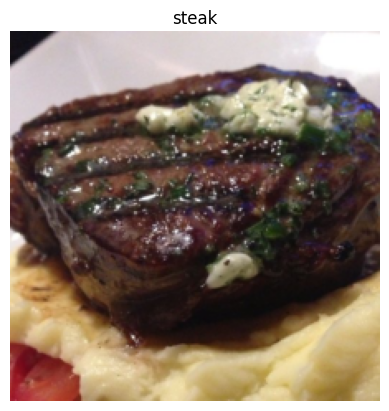

In [7]:
# Check dataloader
images, labels = next(iter(train_dataloader))
image = images[0]
label = labels[0]

class_names = ['pizza', 'steak', 'sushi']

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis("off");

# **=== 3. Vision transformer (ViT) ===**
1. Path embedding : ```x_input = [class_token, image_path1, image_path2, image_path3 ...]``` each patch is learnable
2. Multi-head-attention : MSA wrapping LayerNorm layer(LN) -> (residual connection) :   
    ``` X_output_MSA_block =  MSA_layer((LN_layer(x_input))) + x_output ```
3. Multilayer-perceptron layer : MLP wrapping LayerNorm(LN) -< (residual connection) :   
    ``` x_output_MLP_block = MLP_layer(LN_layer(X_output_MSA_block)) + x_output ```
4. Output layer (y) :   
    ``` y = Linear_layer(LN_layer(x_output_MLP_block[0]))```

## 3.1 Equation 1 : Patch embedding
(`CLASS TOKEN EMBEDDING`, `PATCH EMBEDDING`) + `POSITION EMBEDDING`

### 3.1.1 Split data into patches
patch_embedding 期待的輸入為 H * W * C (2d圖高, 2d圖寬, 色彩通道)  
patch_embedding 期待的輸出為 N * (P*P * C) -> 1D sequence of flattened 2D patches

Split data into patches, explanation step by step

In [8]:
height = 224
width = 224
color_channel = 3
patch_size = 16

number_of_patchs = int(height * width) / patch_size ** 2
print(f"Number of patch with image height={height}, width={width} and patch_size={patch_size} -> {number_of_patchs}")

Number of patch with image height=224, width=224 and patch_size=16 -> 196.0


In [9]:
# Input shape
embedding_layer_input_shape = (height, width, color_channel)

# Output shape
embedding_layer_output_shape = (number_of_patchs, patch_size ** 2 * color_channel)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196.0, 768)


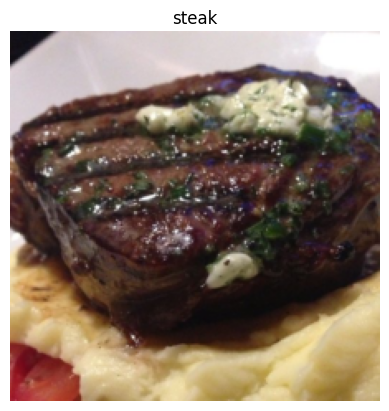

In [10]:
# Single image from train_dataset
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis("off");

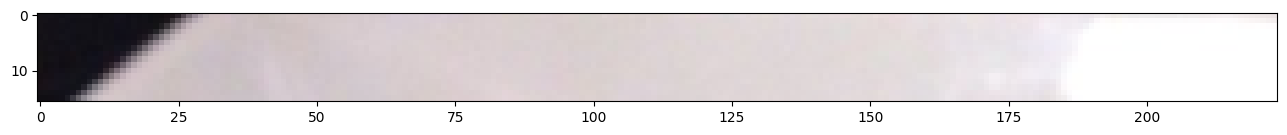

In [11]:
image_permuted = image.permute(1, 2, 0) # (height, width, color_channel)

#
patch_size = 16
plt.figure(figsize = (16, 16))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patch per row: 196.0,
Each patch's shape: (16 * 16)


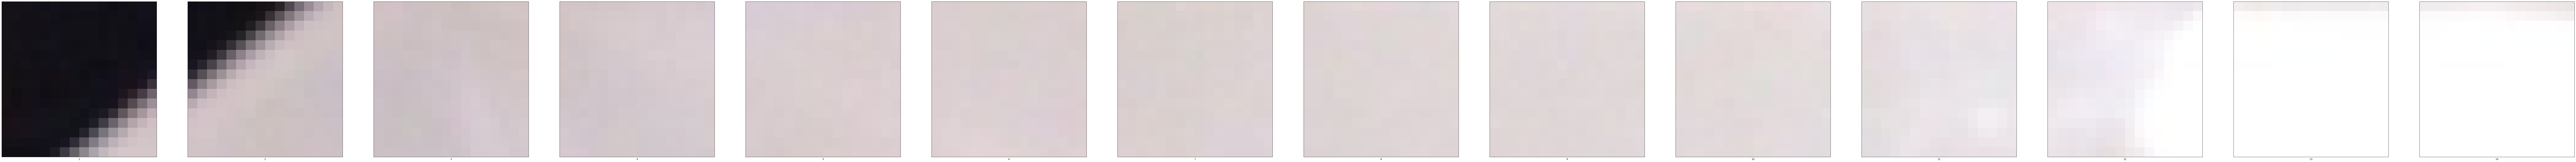

In [15]:
image_size = 224
patch_size = 16
assert image_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patch per row: {number_of_patchs},\nEach patch's shape: ({patch_size} * {patch_size})")

fig, axs = plt.subplots(nrows = 1,
                        ncols = image_size // patch_size,
                        figsize = (number_of_patchs, number_of_patchs),
                        sharex = True,
                        sharey = True)

for i, patch in enumerate(range(0, image_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


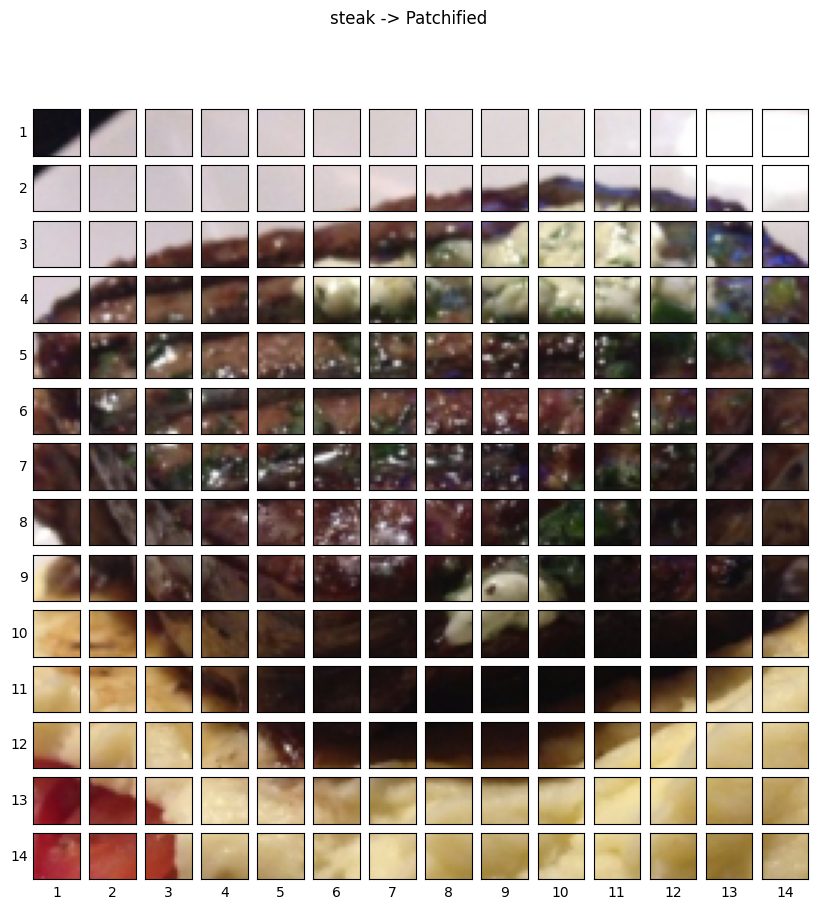

In [16]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Subplot
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(10, 10),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iter through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iter through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified")
plt.show()

Each patch through **`one kernel`**

In [17]:
# ViT-Base -> Layers: 12 / Hidden sizeD: 768 / MLP size: 3072 / Heads: 16 / params: 86 Million
from torch import nn

conv2d = nn.Conv2d(in_channels = 3,
                   out_channels = 768,
                   kernel_size = patch_size,
                   stride = patch_size, # 一個patch conv2d 後, 就移動到下一個patch
                   padding = 0)

In [18]:
image_out_of_conv2d = conv2d(image.unsqueeze(dim=0))
print(image_out_of_conv2d.shape)
# batch_size, embedding dimension, feature_map_height, feature_map_width   ->   每一個ptach 都變成 768特徵

torch.Size([1, 768, 14, 14])


Showing random features from indexs: [53, 62, 230, 241, 401]


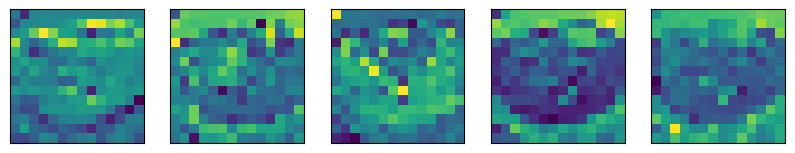

In [19]:
# 隨機從 768 中 挑 5 個特徵 檢視
import random

random_idx = random.sample(range(0, 768), k=5)
print(f"Showing random features from indexs: {random_idx}")

fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize = (10, 10))

for i, idx in enumerate(random_idx):
    image_in_768 = image_out_of_conv2d[:, idx, :, :]
    axs[i].imshow(image_in_768.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [20]:
# 整張圖: 經過conv2d(in=3, out=768) 由RGB三通道 -> 768通道
# 各通道: 經過 kernel_size=16*16 & stride 16 後, 變成 一個tensor 14 * 14
# Flatten: 768通道, 196

# nn.Flatten()
flatten = nn.Flatten(start_dim = 2, end_dim = 3) # 將index 從2開始到3 的維度一維化

#
image_out_of_conv2d_and_flatten = flatten(image_out_of_conv2d)

In [21]:
print(f"Original image shape: {image.shape}")
print(f"Image feature map shape: {image_out_of_conv2d.shape}")
print(f"Flatten image feature map shape: {image_out_of_conv2d_and_flatten.shape}")

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flatten image feature map shape: torch.Size([1, 768, 196])


In [22]:
# 使其符合指定輸出 shape
shaped_image_out_of_conv2d_and_flatten = image_out_of_conv2d_and_flatten.permute(0, 2, 1)
print(shaped_image_out_of_conv2d_and_flatten.shape)

# 從 768 種線性特徵中挑出其中一種
single_flattened_feature_map = shaped_image_out_of_conv2d_and_flatten[:, :, 0]

torch.Size([1, 196, 768])


In [78]:
"""
目前我們已經將一張 2維彩色圖片 轉換為: 1D learnable embedding vector
"""

'\n目前我們已經將一張 2維彩色圖片 轉換為: 1D learnable embedding vector\n'

### 3.1.2 Patch embedding layer to module
將 3.2.1 轉為 class

In [25]:
class PatchEmbedding(nn.Module):
    """
    Turns a 2D image into 1D sequence learnable embedding vector.

    Args:
        in_channels (int): 輸入圖像的色彩通道, default: 3
        patch_size (int): 每個 patch 大小, default: 16
        embedding_dim (int): embedding 嵌入向量的維度大小, default: 768
    """
    def __init__(self,
                 in_channels: int = 3,
                 patch_size: int = 16,
                 embedding_dim: int = 768):
        super().__init__()

        # This layer turn image into patches
        self.patcher = nn.Conv2d(in_channels = in_channels,
                                 out_channels = embedding_dim,
                                 kernel_size = patch_size,
                                 stride = patch_size,
                                 padding = 0)

        # This layer turn patches into 1D
        self.flatten = nn.Flatten(start_dim = 2,
                                  end_dim = 3)

    def forward(self ,x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Image size must be divisible by patch_size, input shape: {image_resolution}, patch_size: {patch_size}"

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        return x_flattened.permute(0, 2, 1)

In [27]:
image.size()

torch.Size([3, 224, 224])

In [35]:
# 測試 class PatchEmbedding -1

patchify = PatchEmbedding(in_channels = 3, patch_size = 16, embedding_dim = 768)

print(f"Image original size: {image.size()}")
print(f"Image unsqueeze size: {image.unsqueeze(dim = 0).size()} -> added batch size")

image_through_patch_embedded = patchify(image.unsqueeze(dim = 0))
print(f"Image through patch embedding layer size: {image_through_patch_embedded.size()}")

Image original size: torch.Size([3, 224, 224])
Image unsqueeze size: torch.Size([1, 3, 224, 224]) -> added batch size
Image through patch embedding layer size: torch.Size([1, 196, 768])


In [40]:
# 測試 class PatchEmbedding -2

random_input_image_correct = (1, 3, 224, 224)
random_input_image_error = (1, 3, 225, 225)

summary(patchify,
        input_size = random_input_image_correct,
        col_names = ["output_size", "num_params", "trainable"],
        col_width = 17)

Layer (type:depth-idx)                   Output Shape      Param #           Trainable
PatchEmbedding                           [1, 196, 768]     --                True
├─Conv2d: 1-1                            [1, 768, 14, 14]  590,592           True
├─Flatten: 1-2                           [1, 768, 196]     --                --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

### 3.1.3 Creating class token embedding

In [43]:
print(image_through_patch_embedded)
print(f"Patch embedding size: {image_through_patch_embedded.size()} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.1597, -0.0016, -0.2115,  ..., -0.1029,  0.0529, -0.3182],
         [ 0.2061,  0.1927, -0.2318,  ..., -0.1203, -0.0857, -0.1671],
         [ 0.1831,  0.0325, -0.0991,  ..., -0.1835, -0.3720,  0.1377],
         ...,
         [ 0.1274,  0.0862, -0.1113,  ..., -0.1270, -0.4183,  0.3138],
         [ 0.0615,  0.1201, -0.1299,  ..., -0.1699, -0.3196,  0.1479],
         [ 0.1344,  0.1778, -0.1883,  ..., -0.1462, -0.3395,  0.1264]]],
       grad_fn=<PermuteBackward0>)
Patch embedding size: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [68]:
# class token
# torch.ones -> 僅為了測試 class token / 實際場景 需要使用 torch.randn()

batch_size = image_through_patch_embedded.shape[0]
embedding_dimension = image_through_patch_embedded.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad = True)

print(f"class_token 1-10 elements: {class_token[:, :, :10]}\n"
      f"class_token's size: {class_token.size()}")

class_token 1-10 elements: tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]])
class_token's size: torch.Size([1, 1, 768])


In [72]:
patch_embedding_with_class_embedding = torch.cat((class_token, image_through_patch_embedded),
                                                 dim = 1)

print(patch_embedding_with_class_embedding)

print(f"\nBefore prepended:\n{image_through_patch_embedded.size()}\n")
print(f"After class_token prepended to patch_embedding:\n{patch_embedding_with_class_embedding.size()}")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.1597, -0.0016, -0.2115,  ..., -0.1029,  0.0529, -0.3182],
         [ 0.2061,  0.1927, -0.2318,  ..., -0.1203, -0.0857, -0.1671],
         ...,
         [ 0.1274,  0.0862, -0.1113,  ..., -0.1270, -0.4183,  0.3138],
         [ 0.0615,  0.1201, -0.1299,  ..., -0.1699, -0.3196,  0.1479],
         [ 0.1344,  0.1778, -0.1883,  ..., -0.1462, -0.3395,  0.1264]]],
       grad_fn=<CatBackward0>)

Before prepended:
torch.Size([1, 196, 768])

After class_token prepended to patch_embedding:
torch.Size([1, 197, 768])


### 3.1.4 Creating position embedding

In [82]:
# 示範時用 torch.ones 創造 position embedding -> 真實場景 需要使用 torch.randn()

# Number of patches
number_of_patches = int((height * width) / (patch_size * patch_size))

# Get embedding dimension
latest_embedding_dimension = patch_embedding_with_class_embedding.shape[2]

# Create learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches + 1,
                                             latest_embedding_dimension,
                                             requires_grad = True))

print(f"First 10 sequence and 10 position embedding:\n{position_embedding[:, :10, :10]}")
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

First 10 sequence and 10 position embedding:
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [85]:
# "Add" position embedding to patch_and_class_token_embedding
patch_and_position_embedding = patch_embedding_with_class_embedding + position_embedding

print(patch_and_position_embedding)
print(f"\nClass token embedding (prepended)\nPatch embedding\n'Add' position embedding\n{patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.8403, 0.9984, 0.7885,  ..., 0.8971, 1.0529, 0.6818],
         [1.2061, 1.1927, 0.7682,  ..., 0.8797, 0.9143, 0.8329],
         ...,
         [1.1274, 1.0862, 0.8887,  ..., 0.8730, 0.5817, 1.3138],
         [1.0615, 1.1201, 0.8701,  ..., 0.8301, 0.6804, 1.1479],
         [1.1344, 1.1778, 0.8117,  ..., 0.8538, 0.6605, 1.1264]]],
       grad_fn=<AddBackward0>)

Class token embedding (prepended)
Patch embedding
'Add' position embedding
torch.Size([1, 197, 768])


### 3.1.5 Equation 1 sum up & recap

1. Setting patch size (ViT base - 16)
2. Check input image's height & width
3. Add a batch dimension for `patch embedding` (patch_size = 16, embedding_dim = 768)
4. Create `class token embedding`
5. **_Prepended_** `class token embedding`
6. Create `position embedding`
7. **_Adding_** `position embedding` to `class token and patch embedding`

In [106]:
# 參數
PATCH_SIZE = 16
EMBEDDING_DIM = 768

# 紀錄 : 圖像高, 寬
print(f"Original image -> shape: {image.shape}")
image_height, image_width = image.shape[1], image.shape[2]

# Add batch size
X = image.unsqueeze(dim = 0)
print(f"Image add batch size -> shape: {X.shape}")

# Use patch embedding function
patch_embedding_layer =  PatchEmbedding(in_channels = 3, patch_size = PATCH_SIZE, embedding_dim = EMBEDDING_DIM)

# Image through patch embedding layer
X_patch_embedding = patch_embedding_layer(X)
print(f"Image after patch embedding -> shape: {X_patch_embedding.shape}")

# Create class token embedding
batch_size = X_patch_embedding.shape[0]
embedding_dimension = X_patch_embedding.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad = True)
print(f"\nClass token embedding -> shape: {class_token.shape}")

# Prepended class token embedding
patch_embedding_class_token = torch.cat((class_token, X_patch_embedding), dim = 1)
print(f"Class token prepended -> shape: {patch_embedding_class_token.shape}")

# Create position embedding
number_of_patches = int((image_height * image_width) / (PATCH_SIZE * PATCH_SIZE))
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad = True)

# "Add" position embedding to patch_embedding_with_class_token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"\nPatch and position embedding -> shape: {patch_and_position_embedding.shape}")

Original image -> shape: torch.Size([3, 224, 224])
Image add batch size -> shape: torch.Size([1, 3, 224, 224])
Image after patch embedding -> shape: torch.Size([1, 196, 768])

Class token embedding -> shape: torch.Size([1, 1, 768])
Class token prepended -> shape: torch.Size([1, 197, 768])

Patch and position embedding -> shape: torch.Size([1, 197, 768])


## 3.2 Equation 2 : Multi-Head attention
* Normalization (Layer Normalization, LN) -> 對每個位置的特徵標準化
* Multi-Head attention -> 計算注意力權重, 將序列中不同位置關聯起來, 判斷: 圖片相依性 or 上下文關係
* Residual connection -> 殘差連接: `輸入multi-head attention前` + `輸入multi-head attention後`, 舒緩梯度消失問題

### 3.2.1 The LayerNorm (LN) layer

In [107]:
# Patch embedding 最後輸出
print(f"\nPatch and position embedding -> shape: {patch_and_position_embedding.shape}")


Patch and position embedding -> shape: torch.Size([1, 197, 768])


In [110]:
# MSA block (尚未添加殘差層)

class MSA(nn.Module):
    """Multi-head self-attention block"""
    def __init__(self,
                 embedding_dim: int = 768,
                 num_heads: int = 12,
                 attn_dropout: float = 0):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)

        self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dim,
                                                    num_heads = num_heads,
                                                    dropout = attn_dropout,
                                                    batch_first = True)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query = x,
                                             key = x,
                                             value = x,
                                             need_weights = False)
        return attn_output

In [122]:
# 通過 MSA block, shape 沒有改變, 但內容有改變

msa_block = MSA(embedding_dim = 768, num_heads = 12)

patched_image_through_msa = msa_block(patch_and_position_embedding)

print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Some content before MSA block:\n{patch_and_position_embedding[:,:3,:3]}\n")
print(f"Output shape of MSA block: {patched_image_through_msa.shape}")
print(f"Some content after MSA block:\n{patched_image_through_msa[:,:3,:3]}")

Input shape of MSA block: torch.Size([1, 197, 768])
Some content before MSA block:
tensor([[[2.0000, 2.0000, 2.0000],
         [0.9993, 1.1760, 1.0056],
         [1.0070, 0.9186, 0.7844]]], grad_fn=<SliceBackward0>)

Output shape of MSA block: torch.Size([1, 197, 768])
Some content after MSA block:
tensor([[[-0.5578,  0.2367, -0.7942],
         [-0.5379,  0.2264, -0.8016],
         [-0.5414,  0.2246, -0.8043]]], grad_fn=<SliceBackward0>)


## 3.3 Equation 3:

## 3.4 Equation 4:

# **=== 4. temp ===**